In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [86]:
def get_dark_channel(img, wind_size):
    dark_channel = np.zeros((img.shape[0], img.shape[1]))
    img = cv2.copyMakeBorder(img,wind_size//2,wind_size//2,wind_size//2,wind_size//2,cv2.BORDER_CONSTANT,value=[255,255,255])    
    no_rows = img.shape[0]
    no_cols = img.shape[1]
    min_channel = np.zeros((no_rows, no_cols))
    for row in range(no_rows):
        for col in range(no_cols):
            min_channel[row-wind_size//2][col-wind_size//2] = np.min(img[row,col,:])
    for row in range(wind_size//2, no_rows-wind_size//2):
        for col in range(wind_size//2, no_cols-wind_size//2):
            dark_channel[row-wind_size//2][col-wind_size//2] = np.min(min_channel[row-wind_size//2:row+wind_size//2,col-wind_size//2:col+wind_size//2])
    return dark_channel

In [87]:
def get_atm_light(im, dark_channel_img):
    img = im.copy()
    num_pixels = dark_channel_img.size
    num_brightest = num_pixels//1000
    haze_density_sort_idx = np.argsort(dark_channel_img,axis=None)[::-1]
    brightest = haze_density_sort_idx[0:num_brightest]
    brightest = np.unravel_index(brightest,dark_channel_img.shape)
    brightest_pixels = img[brightest]
    top_intensities = np.average(brightest_pixels, axis=1)
    max_intensity = np.argmax(top_intensities)
    A = brightest_pixels[max_intensity]
    img[brightest]=[255,0,0]
    row_min = np.min(brightest[0])
    row_max = np.max(brightest[0])
    col_min = np.min(brightest[1])
    col_max = np.max(brightest[1])
    cv2.rectangle(img, (col_min,row_min),(col_max,row_max),(0,0,255),thickness=2)
    return A

In [88]:
def refine(img, transmission, radius, epsilon):
    mean_guide = cv2.blur(img,(radius,radius))
    mean_trans = cv2.blur(transmission,(radius,radius))
    mean_gt = cv2.blur(img * transmission, (radius,radius))
    
    a = mean_gt - mean_guide * mean_trans
    var_guide = cv2.blur(img * img,(radius,radius)) - (mean_guide * mean_guide)
    a = a/(var_guide + epsilon)
    b = mean_trans - a * mean_guide

    q = cv2.blur(a,(radius,radius)) * img + cv2.blur(b,(radius,radius))
    return q

In [89]:
def recover_image(img, trans_bar, atm_light, t0):
    trans_recover = np.copy(trans_bar)
    trans_recover[trans_recover < t0] = t0
    J = np.zeros((img.shape))
    J[:,:,0] = ((img[:,:,0] - atm_light[0])/trans_recover) + atm_light[0]
    J[:,:,1] = ((img[:,:,1] - atm_light[1])/trans_recover) + atm_light[1]
    J[:,:,2] = ((img[:,:,2] - atm_light[2])/trans_recover) + atm_light[2]
    return J

In [90]:
def color_balance(img, s):
    out = np.copy(img)
    hist = np.zeros((256,1))
    no_of_pixels = img.shape[0] * img.shape[1]
    for i in range(3):
        channel_vals = img[:,:,i]
        for pixel_val in range(256):
            hist[pixel_val] = np.sum((channel_vals == pixel_val)) 
        for pixel_val in range(256):
            hist[pixel_val] = hist[pixel_val-1] + hist[pixel_val]
        Vmin = 0
        while (Vmin < 255 and hist[Vmin] <= no_of_pixels*s):
            Vmin += 1
        Vmax = 255
        while (Vmax > 0 and hist[Vmax] > no_of_pixels*(1-s)):
            Vmax -= 1
        channel_vals[channel_vals < Vmin] = Vmin
        channel_vals[channel_vals > Vmax] = Vmax
        out[:,:,i] = cv2.normalize(channel_vals, channel_vals.copy(), 0, 255, cv2.NORM_MINMAX)
    return out

In [114]:
def run(gt_path, im_path, omega, t0, radius, dark_rad):
    img = cv2.imread(im_path)
    img = cv2.resize(img,(0,0),fx=1/6,fy=1/6)
    dark_channel_img = get_dark_channel(img, dark_rad)
    dark_channel_img = dark_channel_img.astype('uint8')
    atm_light = get_atm_light(img,dark_channel_img)
    t_bar = get_dark_channel(img/atm_light,dark_rad)
    trans_bar = 1-(omega * t_bar)
    i=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)/255
    t_refine = refine(i, trans_bar, radius, 0.0001)
    im = img.astype("double")
    J = recover_image(im, t_refine, atm_light, t0)
    J = ((J-np.min(J))/(np.max(J)-np.min(J)))*255
    cb_J = color_balance(np.uint8(J),0.005)
    gt = cv2.imread(gt_path)
    gt = cv2.resize(gt,(0,0),fx=1/6,fy=1/6)
    E = np.sum((cb_J-gt)**2)/gt.size
    return (10*np.log10(255*255/E))

In [115]:
gt = next(os.walk('./Dataset/O-Haze/GT'))[2]
gt.sort()
hazy = next(os.walk('./Dataset/O-Haze/hazy/'))[2]
hazy.sort()
omega = np.arange(0,1.01,0.05)
PSNR = []
for om in omega:
    p = 0
    for i in range(len(gt)):
        print(str(i) + ' ',end='')
        p += run(os.path.join('./Dataset/O-Haze/GT',gt[i]), os.path.join('./Dataset/O-Haze/hazy',hazy[i]),om,0.1)
    print(p/len(gt))
    PSNR.append(p/len(gt))

0 

TypeError: run() missing 2 required positional arguments: 'radius' and 'dark_rad'

In [81]:
PSNR

[28.062530199109748,
 28.065588004968646,
 28.067724306064374,
 28.06973207340207,
 28.07099439571828,
 28.0709118123459,
 28.071356371891877,
 28.07334148676493,
 28.07241825190669,
 28.071024423191577,
 28.068963479075325,
 28.067129629792245,
 28.065069949183886,
 28.064762788460506,
 28.07199469822072,
 28.081582204515648,
 28.088816785717487,
 28.08681163804922,
 28.08136497058668,
 28.06077165217289,
 28.041014971518877]

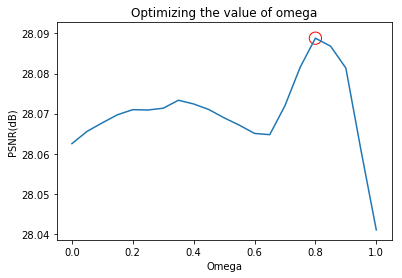

In [112]:
plt.plot(omega,PSNR)
plt.scatter(0.8,PSNR[16],s=150, facecolors='none', edgecolors='r')
plt.xlabel("Omega")
plt.ylabel("PSNR(dB)")
plt.title("Optimizing the value of omega")
plt.show()

In [93]:
gt = next(os.walk('./Dataset/O-Haze/GT'))[2]
gt.sort()
hazy = next(os.walk('./Dataset/O-Haze/hazy/'))[2]
hazy.sort()
PSNR2 = []
radius = [10,20,30,40,50,60,70,80,90,100]
for r in radius:
    p = 0
    for i in range(len(gt)):
        print(str(i) + ' ',end='')
        p += run(os.path.join('./Dataset/O-Haze/GT',gt[i]), os.path.join('./Dataset/O-Haze/hazy',hazy[i]),0.95,0.1,r)
    print(p/len(gt))
    PSNR2.append(p/len(gt))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.065109641665757
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.061728213954584
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.065535962602254
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.060505155606112
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.06183731664401
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.06077165217289
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.0610608288

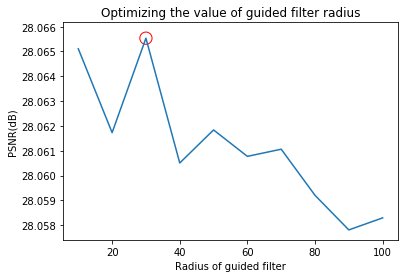

In [113]:
plt.plot(radius,PSNR2)
plt.scatter(30,PSNR2[2],s=150, facecolors='none', edgecolors='r')
plt.xlabel("Radius of guided filter")
plt.ylabel("PSNR(dB)")
plt.title("Optimizing the value of guided filter radius")
plt.show()

In [117]:
gt = next(os.walk('./Dataset/O-Haze/GT'))[2]
gt.sort()
hazy = next(os.walk('./Dataset/O-Haze/hazy/'))[2]
hazy.sort()
PSNR3 = []
dark_window = np.arange(3,40,4)
print(dark_window)
for r in dark_window:
    p = 0
    for i in range(len(gt)):
        print(str(i) + ' ',end='')
        p += run(os.path.join('./Dataset/O-Haze/GT',gt[i]), os.path.join('./Dataset/O-Haze/hazy',hazy[i]),0.85,0.1,30,r)
    print(p/len(gt))
    PSNR3.append(p/len(gt))

[ 3  7 11 15 19 23 27 31 35 39]
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 27.951386367608634
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.034251358393536
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.06518482109126
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.09061501795127
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.105173571264707
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 28.117574306393333
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38

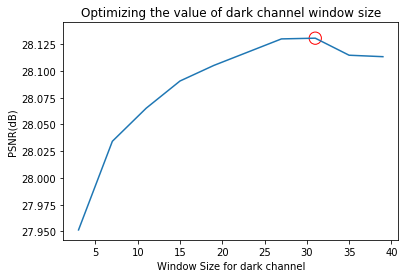

In [130]:
plt.plot(dark_window,PSNR3)
plt.scatter(31,PSNR3[7],s=150, facecolors='none', edgecolors='r')
plt.xlabel("Window Size for dark channel")
plt.ylabel("PSNR(dB)")
plt.title("Optimizing the value of dark channel window size")
plt.show()

[27.951386367608634,
 28.034251358393536,
 28.06518482109126,
 28.09061501795127,
 28.105173571264707,
 28.117574306393333,
 28.129976424689424,
 28.13065078466695,
 28.114717662114508,
 28.11335466389212]